# Load Libraries

In [336]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
import csv
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
import numpy as np
import pingouin as pg

from sklearn.metrics import roc_auc_score, classification_report, roc_curve, accuracy_score

from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

from hyperopt import fmin, tpe, hp

pd.set_option('display.max_columns', None)

In [177]:
# For neural network model (can remove if not running it)
from tensorflow.keras.callbacks import EarlyStopping

## Import Data

In [178]:
# Load data
train_df=pd.read_csv("Data/train.csv")
test_df=pd.read_csv("Data/test.csv")

In [179]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


## Data Preprocessing

In [180]:
# Load data
train_df=pd.read_csv("Data/train.csv")
test_df=pd.read_csv("Data/test.csv")

# Count null values
print("--- NaN occurences in cols: --- \n")
print(train_df.isna().sum().to_string())

# Length of both datasets
print(f"\nLength of train dataframe: {len(train_df)}")
print(f"\nLength of test dataframe: {len(test_df)}")

--- NaN occurences in cols: --- 

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0

Length of train dataframe: 2190

Length of test dataframe: 730


In [181]:
# Identifying incorrectly ordered days
train_df['day_of_year'] = (train_df['id']) % 365 + 1
test_df['day_of_year'] = (test_df['id']) % 365 + 1

train_df['day_since_start'] = train_df['id']
test_df['day_since_start'] = test_df['id']

# Number of rows where day != day or year
df_day_error = train_df[train_df["day"] != train_df["day_of_year"]]
print(f"Out of {len(train_df)}, there are {len(df_day_error)} number of rows with mismatched days")

Out of 2190, there are 35 number of rows with mismatched days


In [182]:
# Remove these incorrectly ordered days
train_df = train_df[train_df["day"] == train_df["day_of_year"]]
test_df = test_df[test_df["day"] == test_df["day_of_year"]]

train_df = train_df.drop(columns=["day"])
test_df = test_df.drop(columns=["day"])

## EDA

Takeaways:

1. Humidity/Cloud/Sunshine - Highly correlated with rainfall.
2. Sunshine and Cloud have a high negative correlation (understandably)
3. Higher humidity = more chance of rainfall


In [183]:
train_df.head()

,id,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,day_of_year,day_since_start
0,0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1,0
1,1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,2,1
2,2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,3,2
3,3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,4,3
4,4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,5,4


In [184]:
continuous_columns=['pressure', 'maxtemp','temparature', 'mintemp', 'dewpoint',
   'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',]

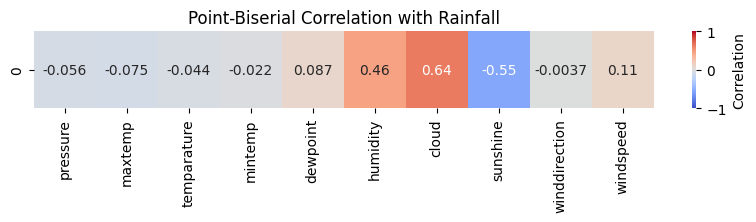

In [185]:
# Function to calculate the point-biserial correlation
def point_biserial_corr(df, continuous_features, binary_feature):
    correlations = []
    for feature in continuous_features:
        corr, _ = pointbiserialr(df[feature], df[binary_feature])
        correlations.append(corr)
    
    # Create a DataFrame for better visualization
    correlation_matrix = pd.DataFrame([correlations], columns=continuous_features)
    return correlation_matrix


# Calculate the point-biserial correlation
correlation_matrix = point_biserial_corr(train_df, continuous_columns, 'rainfall')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 1))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Point-Biserial Correlation with Rainfall')
plt.show()


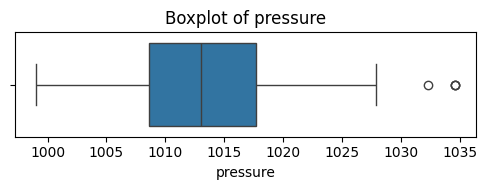

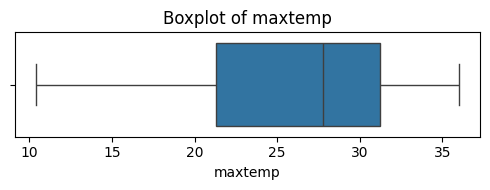

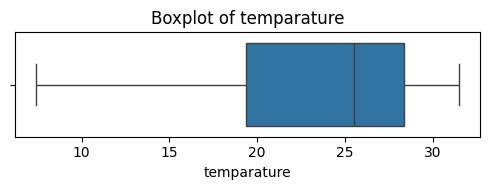

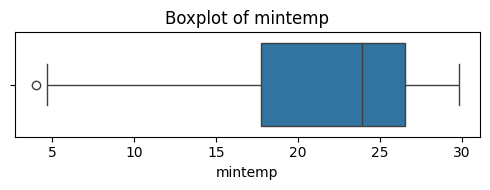

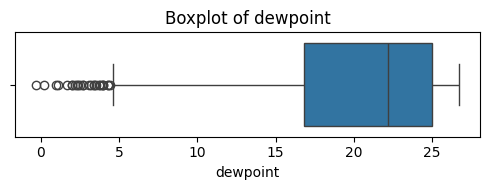

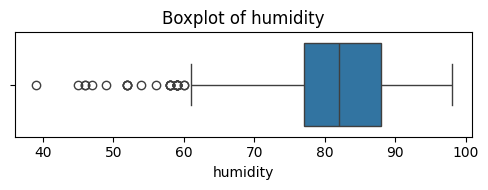

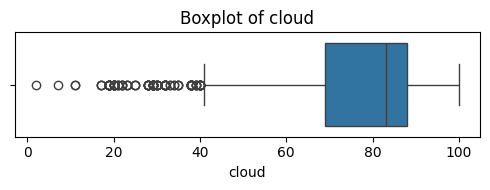

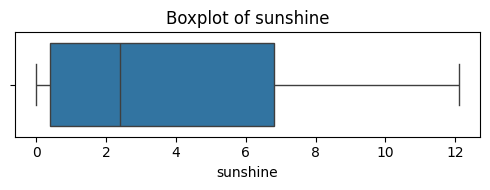

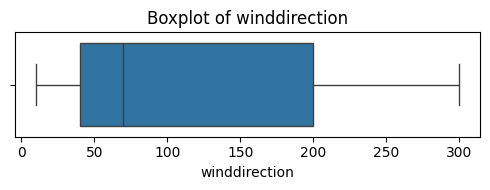

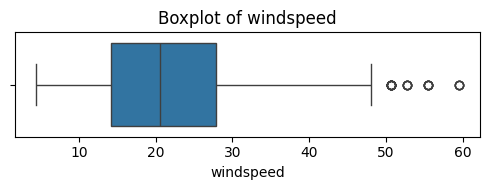

In [186]:
# Plot box and whisker for cont. variables
def plot_boxplots(df, continuous_vars):
    """
    Plots box and whisker plots for the specified continuous variables.

    Parameters:
    df (pandas.DataFrame): The input dataframe.
    continuous_vars (list): A list of column names representing continuous variables.
    """
   

    # Iterate over the list of continuous variables
    
    for i, var in enumerate(continuous_vars):
         # Set the plot size
        plt.figure(figsize=(5, 2))
        sns.boxplot(data=df, x=var)
        plt.title(f'Boxplot of {var}')
        plt.tight_layout()

        plt.show()

plot_boxplots(train_df, continuous_columns)

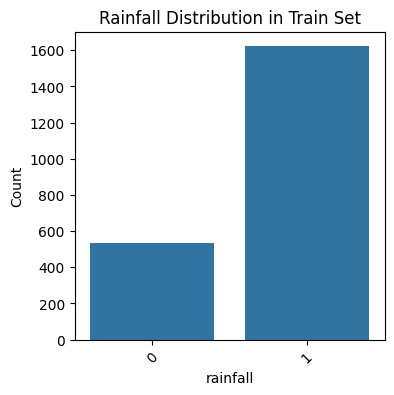

In [187]:
def plot_category_counts(df, categorical_column):
    """
    Plots a bar chart showing the counts of categories in the specified categorical column.

    """
    # Count the occurrences of each category
    category_counts = df[categorical_column].value_counts()

    # Plot the bar chart
    plt.figure(figsize=(4, 4))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    
    # Adding titles and labels
    plt.title(f'Rainfall Distribution in Train Set')
    plt.xlabel(categorical_column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate category labels if necessary

    plt.show()
    
plot_category_counts(train_df, categorical_column='rainfall')

In [188]:
def plot_time_series(df, continuous_cols, time_col='day_of_year'):
    """
    Plots scatter plots of continuous variables over time.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    continuous_cols (list): List of column names containing continuous values.
    time_col (str): The column representing time (default is 'day').
    """
    for col in continuous_cols:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=df[time_col], y=df[col], color='royalblue')
        plt.xlabel(time_col)
        plt.ylabel(col)
        plt.title(f"{col} over {time_col}")
        plt.show()


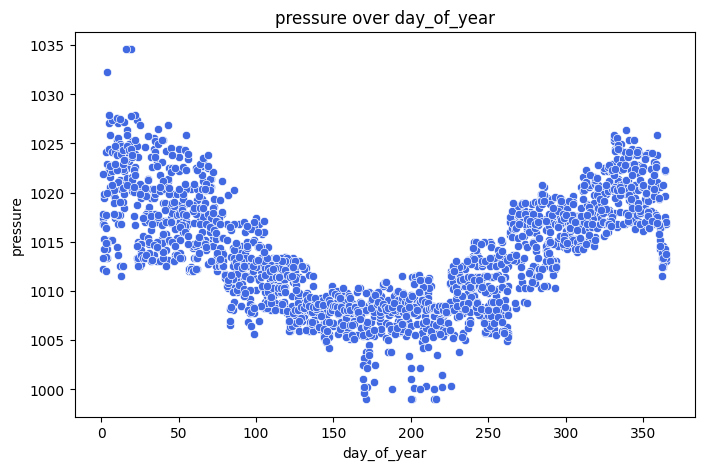

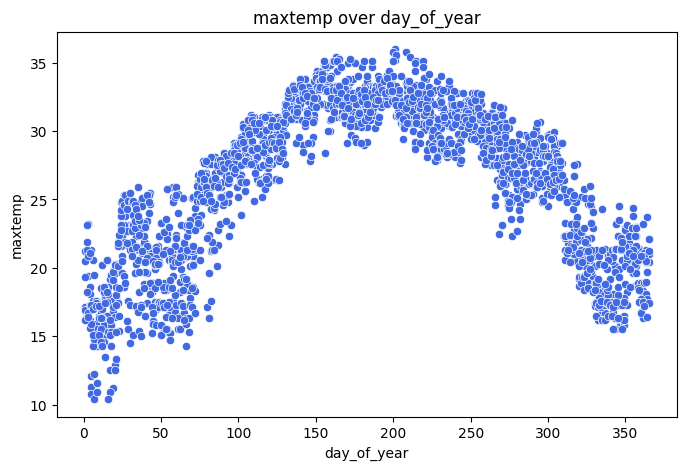

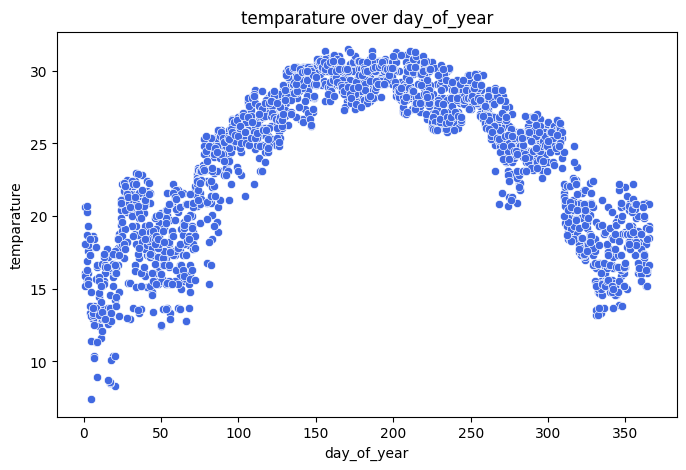

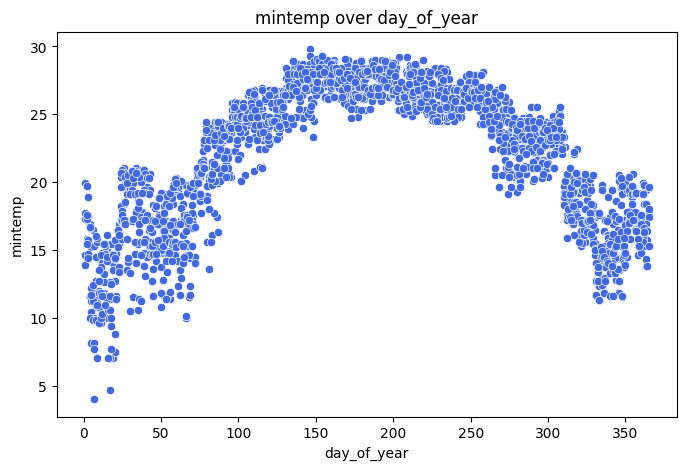

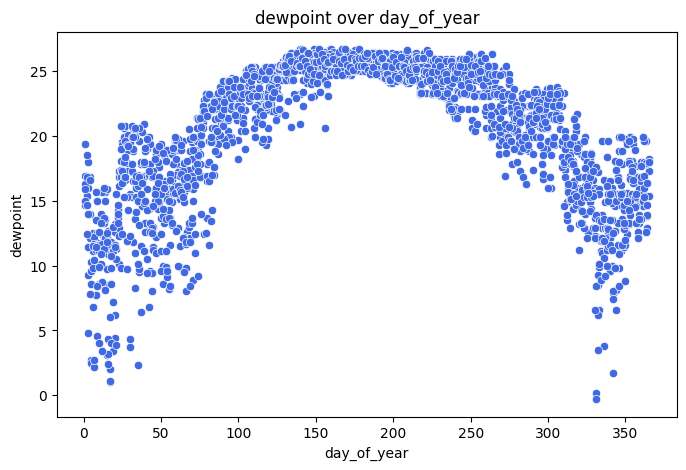

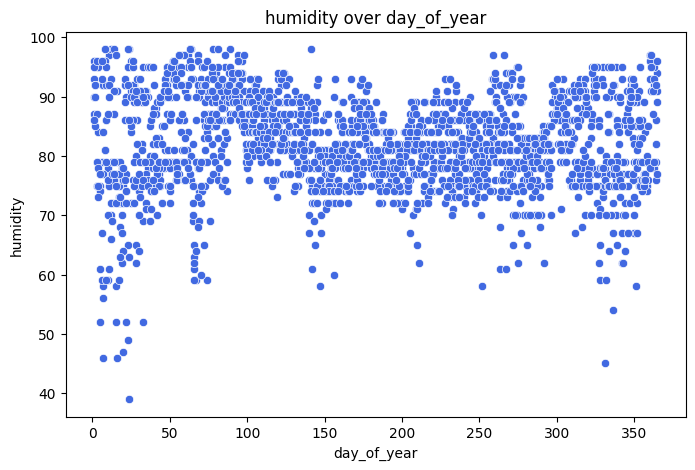

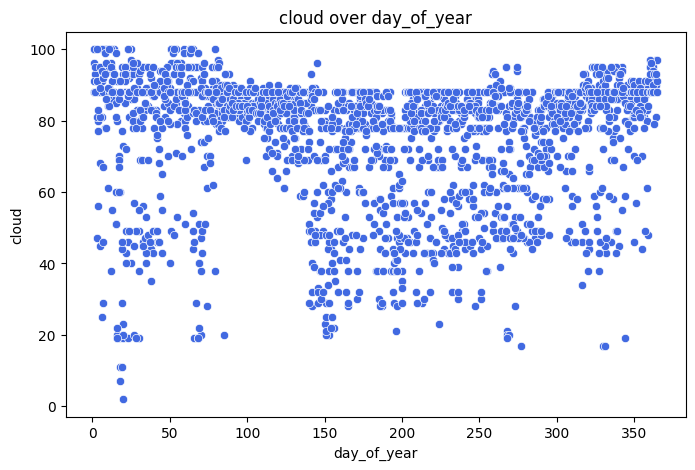

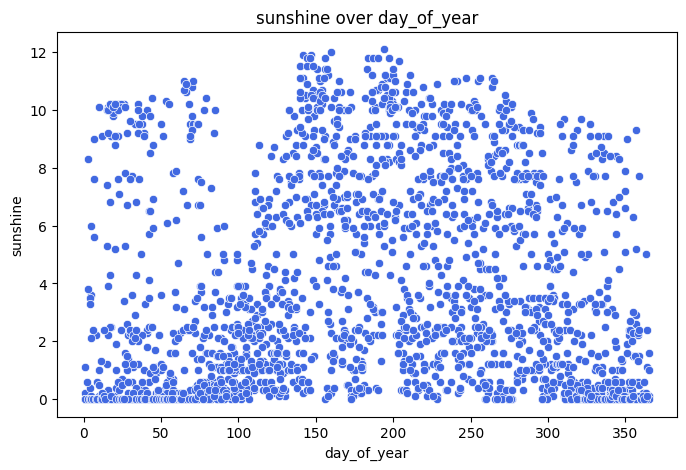

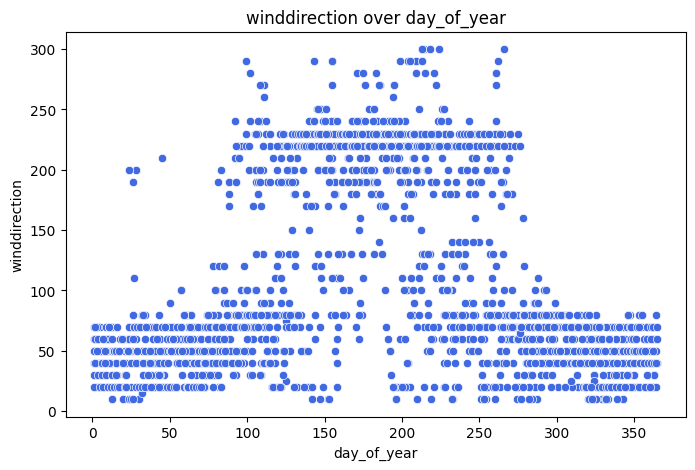

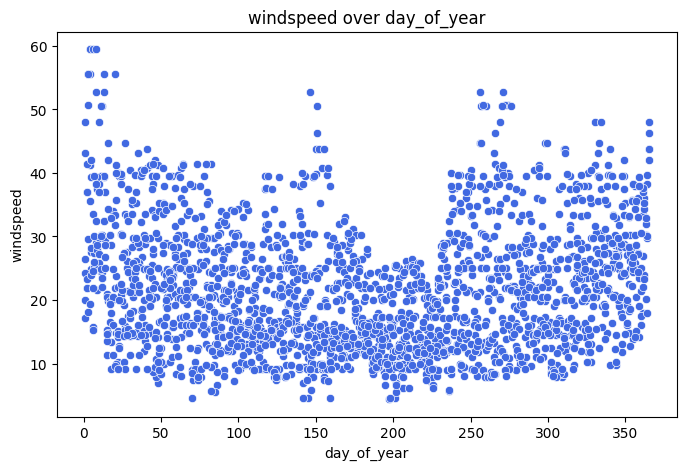

In [189]:
plot_time_series(train_df, continuous_columns, time_col='day_of_year')

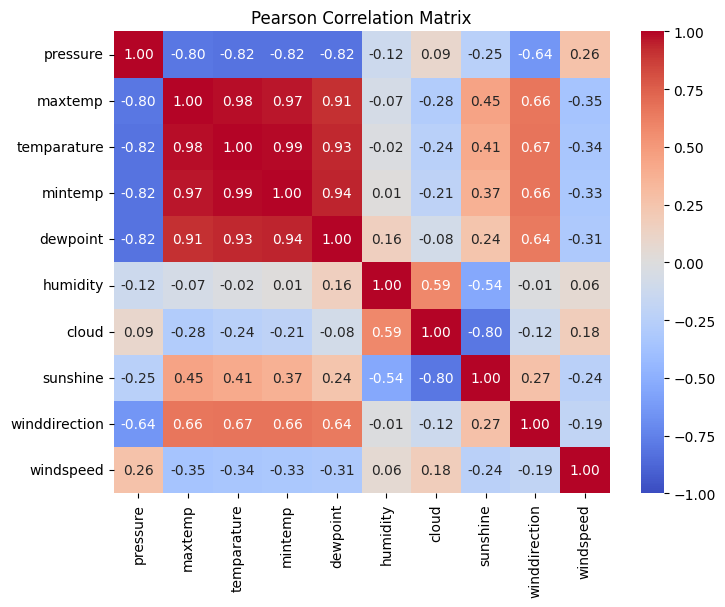

In [190]:
def plot_pearson_correlation_matrix(df, continuous_columns):
    # Ensure the continuous columns are in the DataFrame
    df = df[continuous_columns]
    
    # Calculate Pearson correlation matrix
    correlation_matrix = df.corr(method='pearson')
    
    # Plotting the correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.title('Pearson Correlation Matrix')
    plt.show()

plot_pearson_correlation_matrix(train_df, continuous_columns)

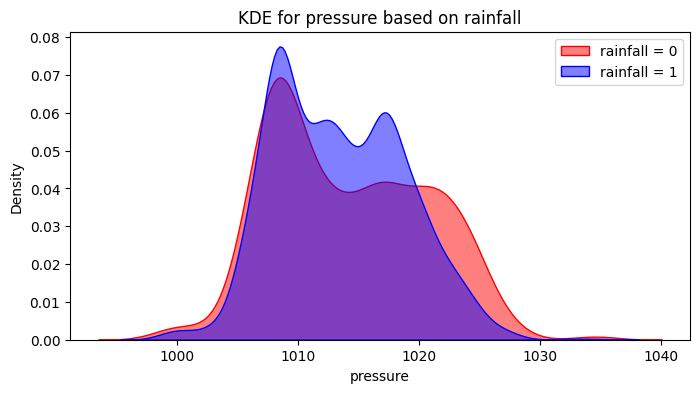

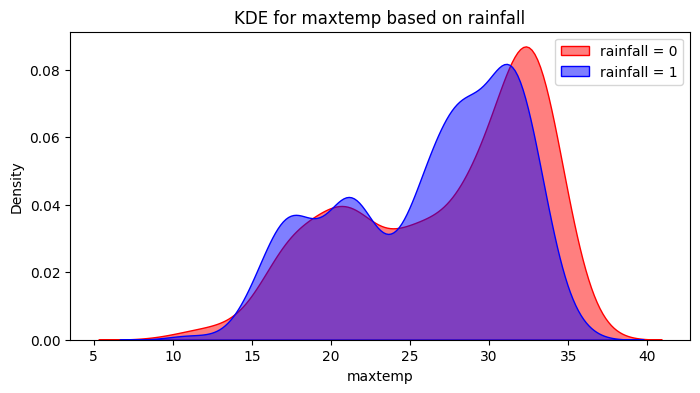

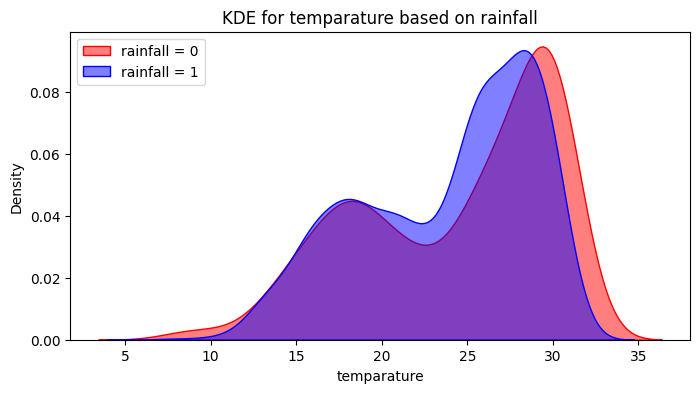

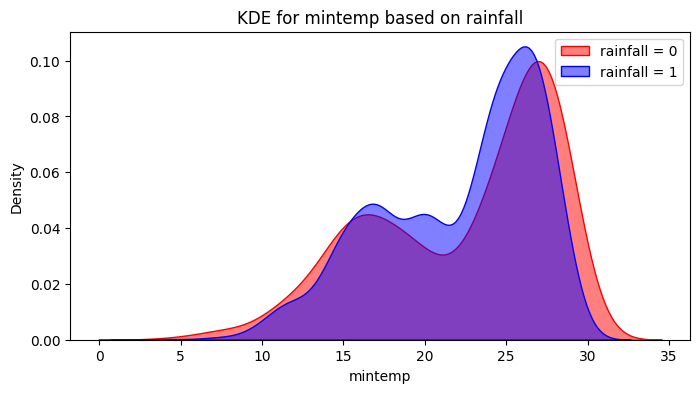

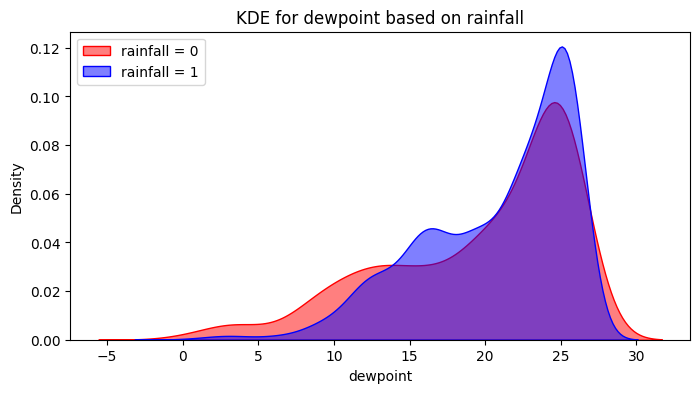

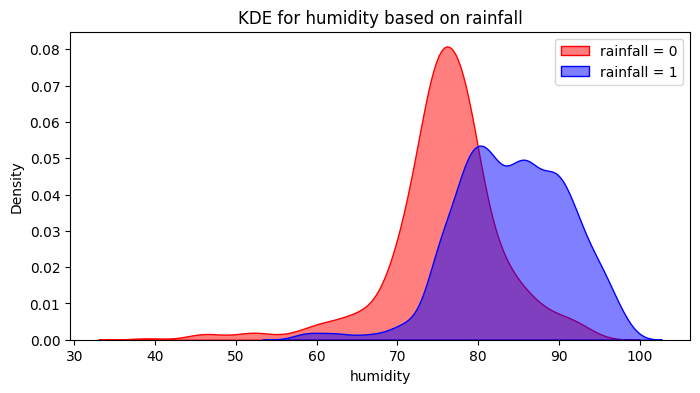

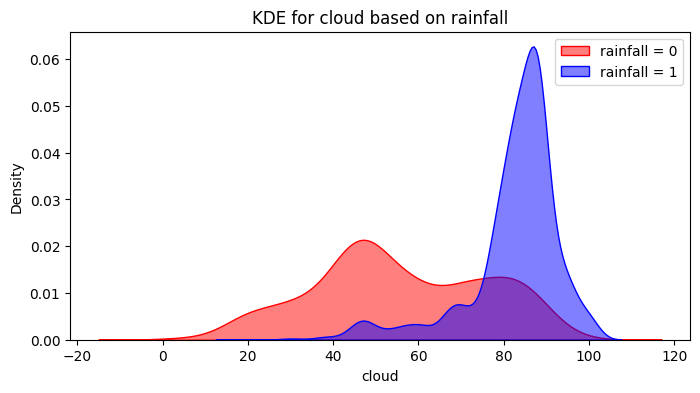

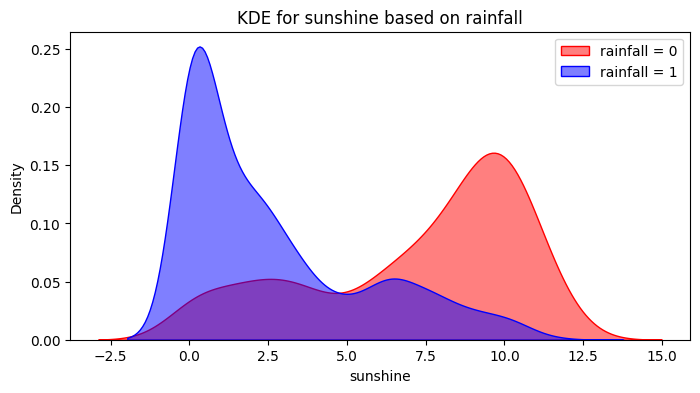

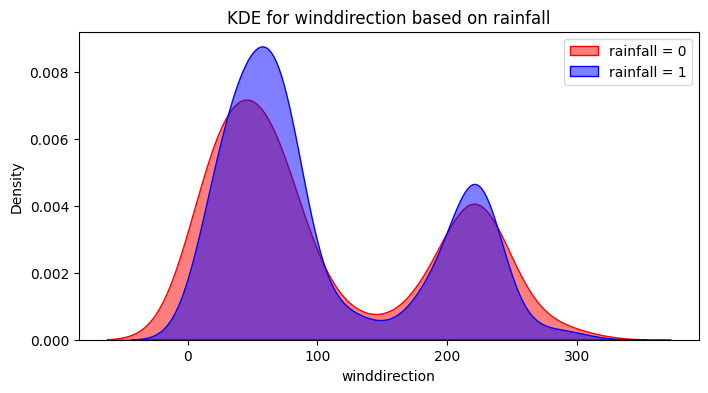

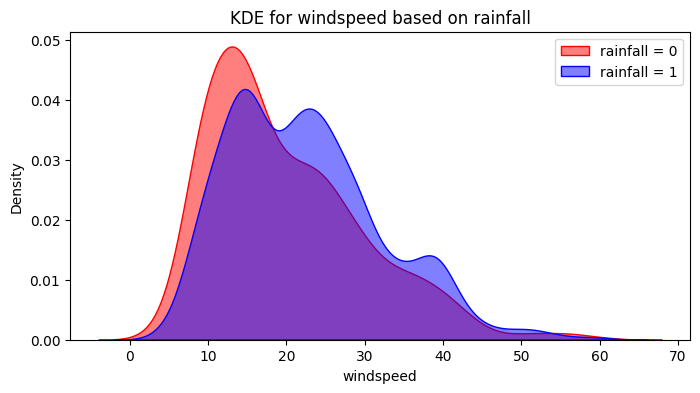

In [191]:
def plot_kde_for_binary(df, columns, target_col):
    """
    Plot KDE for each column in 'columns' list for each unique value (0, 1) in the binary 'target_col'.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of columns to plot KDE for
    - target_col: binary target column to distinguish the groups (0 or 1)
    """
    
    for col in columns:
        plt.figure(figsize=(8, 4))
        
        # Plot KDE for target variable 0
        sns.kdeplot(df[df[target_col] == 0][col], label=f'{target_col} = 0', fill=True, color='red', alpha=0.5)
        
        # Plot KDE for target variable 1
        sns.kdeplot(df[df[target_col] == 1][col], label=f'{target_col} = 1', fill=True, color='blue', alpha=0.5)
        
        plt.title(f'KDE for {col} based on {target_col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
        
plot_kde_for_binary(train_df, continuous_columns, target_col='rainfall')

# Stage 4: Baseline (XGBoost)

In [240]:
def split_dataframe(df, train_size, val_size, test_size, random_state=42):

    # Shuffle and split the data
    train, temp = train_test_split(df, test_size=(test_size + val_size), random_state=random_state, shuffle=True)
    
    # Further split the temp data into test and validation sets
    test, val = train_test_split(temp, test_size=val_size / (test_size + val_size), random_state=random_state, shuffle=True)

    return train, test, val

In [241]:
X_features=['pressure','maxtemp','temparature','mintemp','dewpoint','humidity','cloud',
            'sunshine','winddirection','windspeed']

y_feature='rainfall'

xg_train_df, xg_test_df, xg_val_df = split_dataframe(train_df, train_size=0.7, val_size=0.2, test_size=0.1)

In [282]:
def train_xgboost(X_features, y_feature, train_df, val_df, reg=False):
    
    
    # Extract features and target
    X_train, y_train = train_df[X_features], train_df[y_feature]
    X_val, y_val = val_df[X_features], val_df[y_feature]
    
    
    # Print class distribution
    print("\033[1mOriginal class balance:\033[0;0m")
    print(f"Train set: {sum(y_train==1)} positives, {sum(y_train==0)} negatives")
    print(f"Val set: {sum(y_val==1)} positives, {sum(y_val==0)} negatives")
    
    # Define undersampler with a custom sampling strategy
    undersampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    

    # Apply undersampling
    X_train, y_train = undersampler.fit_resample(X_train, y_train)

    
    # Print class distribution
    print("\n\033[1mPost undersampling class balance:\033[0;0m")
    print(f"Train set: {sum(y_train==1)} positives, {sum(y_train==0)} negatives")
    print(f"Val set: {sum(y_val==1)} positives, {sum(y_val==0)} negatives")

    # Train XGBoost model
    if reg==False:
        model = xgb.XGBClassifier(use_label_encoder=False, 
                                  eval_metric='logloss', 
                                  max_depth=4,
                                  min_child_depth=3,
                                  subsample=1,
                                  colsample_bytree=1,
                                  learning_rate=0.08,
                                  random_state=42)
    
    else:
         model = xgb.XGBClassifier(
            use_label_encoder=False, 
            eval_metric='logloss', 
            max_depth=4,
            min_child_weight=3,
            subsample=1,
            colsample_bytree=0.8,  # Reduce to encourage feature diversity
            learning_rate=0.08,
            reg_lambda=10,  # Increase L2 regularization
            reg_alpha=5,  # Increase L1 regularization
            random_state=42
        )
    
    model.fit(X_train, y_train)
    
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    print("\n\033[1mEvaluation Scores:\033[0;0m")
    print(classification_report(y_val, y_val_pred))
    
    return model


In [261]:
xg_model = train_xgboost(X_features, y_feature, 
                      train_df=xg_train_df, val_df=xg_val_df)

Original class balance:
Train set: 1146 positives, 362 negatives
Val set: 328 positives, 104 negatives

Post undersampling class balance:
Train set: 724 positives, 362 negatives
Val set: 328 positives, 104 negatives

Evaluation Scores:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       104
           1       0.90      0.91      0.90       328

    accuracy                           0.85       432
   macro avg       0.80      0.79      0.79       432
weighted avg       0.85      0.85      0.85       432



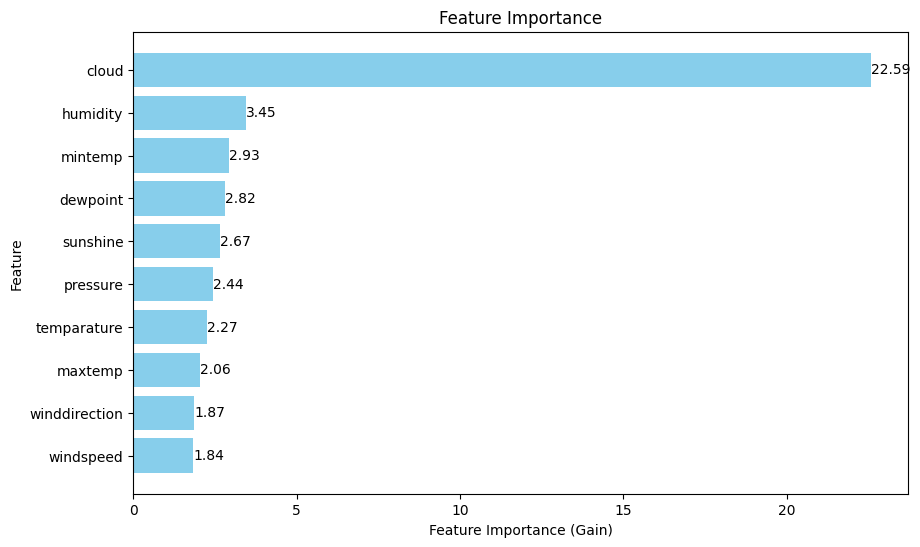

In [262]:
def plot_feature_importance(model, X_features):
    """
    Plots feature importance with scores rounded to 2 decimal places.
    """
    # Get feature importance values
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Convert to sorted list of tuples
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Extract feature names and their rounded importance values
    feature_names = [name for name, _ in sorted_importance]
    importance_values = [round(value, 2) for _, value in sorted_importance]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance_values, color='skyblue')
    plt.xlabel('Feature Importance (Gain)')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    
    # Add value labels
    for i, v in enumerate(importance_values):
        plt.text(v, i, str(v), va='center', fontsize=10)
    
    plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
    plt.show()

# Call function
plot_feature_importance(xg_model, X_features)


## Further Data Preprocessing

Takeaways:

* Rolling 3 day means very impactful
* Temp difference impactful
* All 3 interaction terms very impactful: cloud_humidity, sunshine_cloud, sunshine_humidity

In [263]:
def wind_sector(direction):
    if pd.isna(direction):
        return np.nan  # Preserve missing values for later handling
    direction = float(direction)
    if direction >= 315 or direction < 45:
        return 'North'
    elif direction >= 45 and direction < 135:
        return 'East'
    elif direction >= 135 and direction < 225:
        return 'South'
    else:
        return 'West'

In [264]:
# Add in new vars: rolling (5 day) for humidity, cloud, sunshine. Bucket wind direction. Temp difference
def additional_feature_engineering(df):
    
    # Rolling 3 day mean - humidity, cloud, sunshine
    df['cloud_roll3_mean'] = (df['cloud']
                              .rolling(window=3, min_periods=1)
                              .mean()
                              .fillna(method='bfill'))
    df['sunshine_roll3_mean'] = (df['sunshine']
                                 .rolling(window=3, min_periods=1)
                                 .mean()
                                 .fillna(method='bfill'))
    df['humidity_roll3_mean'] = (df['humidity']
                                 .rolling(window=3, min_periods=1)
                                 .mean()
                                 .fillna(method='bfill'))
    
    # 1 day lag - humidity, cloud, sunshine
    df['cloud_lag1'] = df['cloud'].shift(1).fillna(0)
    df['sunshine_lag1'] = df['sunshine'].shift(1).fillna(0)
    df['humidity_lag1'] = df['humidity'].shift(1).fillna(0)
    
    # Bucket wind directions
    df['wind_sector'] = df['winddirection'].apply(wind_sector).fillna('Unknown')
    
    # Temperature min-max difference
    df['temp_range'] = (df['maxtemp'] - df['mintemp']).fillna(df['maxtemp'].median())
    
    # Pressure difference from yesterday
    df['pressure_diff'] = df['pressure'].diff().fillna(0)
    
    # Sin calculation for day
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    
    # Interaction terms 
    df['cloud_humidity'] = (df['cloud'] * df['humidity']).fillna(0)  # The effect of cloud cover on rainfall increases as humidity increase
    df['sunshine_cloud'] = (df['sunshine'] * df['cloud']).fillna(0)  # The effect of sunshine on rainfall increases as cloud cover increase
    df['sunshine_humidity'] = (df['sunshine'] * df['humidity']).fillna(0)  # The effect of sunshine on rainfall increases as humidity increase
    
    # Add a month column
    df['month'] = ((df['day_of_year'] - 1) // 30) + 1
    df['month'] = df['month'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                                                7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})


    return df

train_df=additional_feature_engineering(train_df)
test_df=additional_feature_engineering(test_df)

In [265]:
# Numeric new features
new_cont_vars = [
    'day_sin',              # Sine of day for seasonality
    'cloud_lag1',           # Previous day's cloud cover
    'sunshine_lag1',        # Previous day's sunshine duration
    'humidity_lag1',        # Previous day's humidity
    'cloud_roll3_mean',     # 3-day average cloud cover
    'sunshine_roll3_mean',  # 3-day average sunshine duration
    'humidity_roll3_mean',  # 3-day average humidity
    'temp_range',           # Daily temperature range
    'pressure_diff',        # Change in pressure from previous day
    'cloud_humidity', # Interaction term
    'sunshine_cloud', # Interaction term
    'sunshine_humidity' # Interaction term
]

# Categorical new features
new_cat_vars = [
    'wind_sector'           # Wind direction binned into North, East, South, West
]

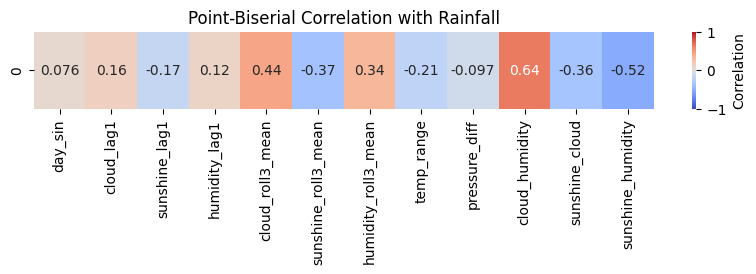

In [266]:
# Calculate the point-biserial correlation
correlation_matrix = point_biserial_corr(train_df, new_cont_vars, 'rainfall')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 1))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title('Point-Biserial Correlation with Rainfall')
plt.show()


In [267]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Example usage
print(f"Correlation between wind cat and rainfall: {round(cramers_v(train_df['wind_sector'], train_df['rainfall']),3)}")
print(f"Correlation between month and rainfall: {round(cramers_v(train_df['month'], train_df['rainfall']),3)}")


Correlation between wind cat and rainfall: 0.082
Correlation between month and rainfall: 0.174


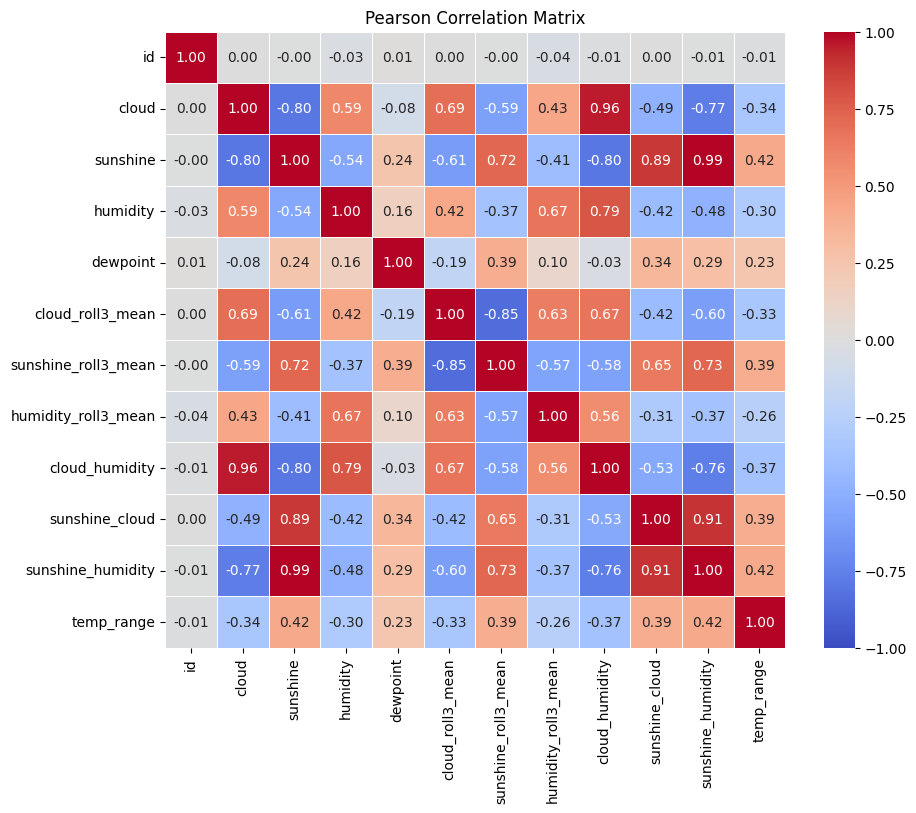

In [209]:
def plot_correlation_matrix(df, columns):
    """
    Plots a Pearson correlation coefficient matrix for the given list of continuous columns.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    columns (list): List of continuous column names to include in the correlation matrix.
    """
    corr_matrix = df[columns].corr(method='pearson')  # Compute correlation matrix

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Pearson Correlation Matrix")
    plt.show()

selected_features_for_correlation = [
'id',
'cloud',
'sunshine',
'humidity',
'dewpoint',
'cloud_roll3_mean',
'sunshine_roll3_mean',
'humidity_roll3_mean',
'cloud_humidity',
'sunshine_cloud',
'sunshine_humidity',
'temp_range']
    
plot_correlation_matrix(train_df, selected_features_for_correlation)

# XGBoost - refined

In [405]:
# potential_new_features=[
# 'cloud_roll3_mean',
# 'sunshine_roll3_mean',
# 'humidity_roll3_mean',
# 'cloud_humidity',
# 'sunshine_cloud',
# 'sunshine_humidity',
# 'temp_range'
# ]

X_features=['pressure','dewpoint','humidity','cloud',
            'sunshine']


y_feature='rainfall'

xg_train_df, xg_test_df, xg_val_df = split_dataframe(train_df, train_size=0.7, val_size=0.2, test_size=0.1)


In [406]:
space={'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'reg_alpha' : hp.quniform('reg_alpha', 2,50,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 50),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'n_estimators': 180,
        'seed': 0
    }

# Hyperparameter tuning dataset
hp_X_train=xg_train_df.drop('rainfall', axis=1, inplace=False)
hp_X_val=xg_train_df.drop('rainfall', axis=1, inplace=False)
hp_y_train=xg_train_df['rainfall']
hp_y_val=xg_train_df['rainfall']

# Extract features and target
hp_X_train, hp_X_val = hp_X_train[X_features], hp_X_val[X_features]

# Print class distribution
print("\033[1mOriginal class balance:\033[0;0m")
print(f"Train set: {sum(hp_y_train==1)} positives, {sum(hp_y_train==0)} negatives")
print(f"Val set: {sum(hp_y_val==1)} positives, {sum(hp_y_val==0)} negatives")

# Define undersampler with a custom sampling strategy
undersampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)


# Apply undersampling
hp_X_train, hp_y_train = undersampler.fit_resample(hp_X_train, hp_y_train)


# Print class distribution
print("\n\033[1mPost undersampling class balance:\033[0;0m")
print(f"Train set: {sum(hp_y_train==1)} positives, {sum(hp_y_train==0)} negatives")
print(f"Val set: {sum(hp_y_val==1)} positives, {sum(hp_y_val==0)} negatives")


# Define the objective function to minimize
def objective(params):
    
    xgb_model = xgb.XGBClassifier(**params)
    
    xgb_model.fit(hp_X_train, hp_y_train)
    hp_y_pred = xgb_model.predict(hp_X_val)
    
    score = accuracy_score(hp_y_val, hp_y_pred)
    
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=1000)

print("Best set of hyperparameters: ", best_params)

Original class balance:
Train set: 1146 positives, 362 negatives
Val set: 1146 positives, 362 negatives

Post undersampling class balance:
Train set: 724 positives, 362 negatives
Val set: 1146 positives, 362 negatives
100%|███████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.22trial/s, best loss: -0.9562334217506632]
Best set of hyperparameters:  {'colsample_bytree': np.float64(0.9881944155093001), 'max_depth': np.int64(11), 'min_child_weight': np.float64(0.0), 'reg_alpha': np.float64(2.0), 'reg_lambda': np.float64(0.30339994647143054)}


In [407]:
def train_xgboost(X_features, y_feature, train_df, val_df, reg=False):
    
    
    # Extract features and target
    X_train, y_train = train_df[X_features], train_df[y_feature]
    X_val, y_val = val_df[X_features], val_df[y_feature]
    
    
    # Print class distribution
    print("\033[1mOriginal class balance:\033[0;0m")
    print(f"Train set: {sum(y_train==1)} positives, {sum(y_train==0)} negatives")
    print(f"Val set: {sum(y_val==1)} positives, {sum(y_val==0)} negatives")
    
    # Define undersampler with a custom sampling strategy
    undersampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    

    # Apply undersampling
    X_train, y_train = undersampler.fit_resample(X_train, y_train)

    
    # Print class distribution
    print("\n\033[1mPost undersampling class balance:\033[0;0m")
    print(f"Train set: {sum(y_train==1)} positives, {sum(y_train==0)} negatives")
    print(f"Val set: {sum(y_val==1)} positives, {sum(y_val==0)} negatives")

    # Train XGBoost model
    model = xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        max_depth=11,
        subsample=1,
        colsample_bytree=0.988,  # Reduce to encourage feature diversity
        learning_rate=0.08,
        reg_alpha=2,  # Increase L1 regularization
        reg_lambda=0.3,  # Increase L2 regularization
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    print("\n\033[1mEvaluation Scores:\033[0;0m")
    print(classification_report(y_val, y_val_pred))
    
    return model


In [408]:
xg_model = train_xgboost(X_features, y_feature, 
                      train_df=xg_train_df, val_df=xg_val_df, reg=True)

Original class balance:
Train set: 1146 positives, 362 negatives
Val set: 328 positives, 104 negatives

Post undersampling class balance:
Train set: 724 positives, 362 negatives
Val set: 328 positives, 104 negatives

Evaluation Scores:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       104
           1       0.91      0.91      0.91       328

    accuracy                           0.86       432
   macro avg       0.81      0.81      0.81       432
weighted avg       0.86      0.86      0.86       432



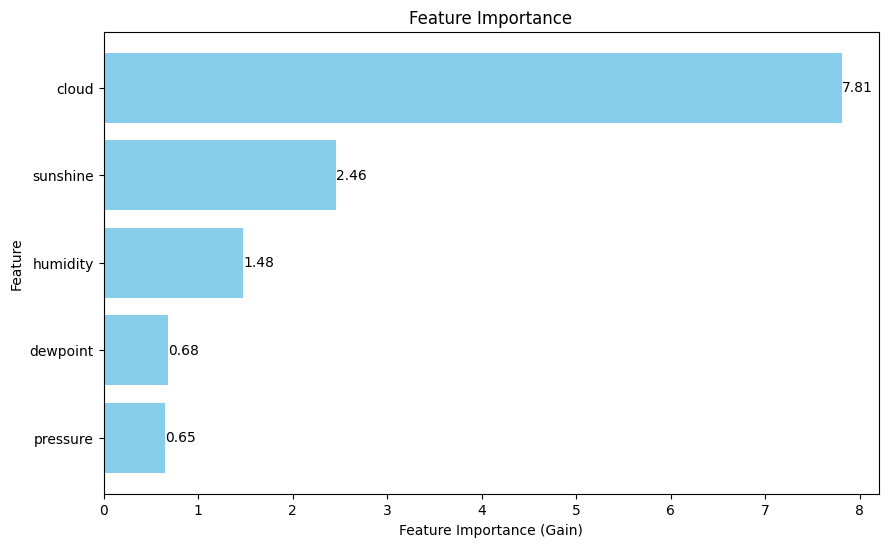

In [403]:
plot_feature_importance(xg_model, X_features)

In [404]:
make_test_set_predictions(xg_model,xg_test_df, X_features, y_feature)

              precision    recall  f1-score   support

           0       0.79      0.72      0.75        67
           1       0.88      0.91      0.89       148

    accuracy                           0.85       215
   macro avg       0.83      0.81      0.82       215
weighted avg       0.85      0.85      0.85       215



# Neural Net - refined

In [427]:
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [428]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [437]:
X_features=['pressure','dewpoint','humidity','cloud',
            'sunshine']

y_feature='rainfall'

nn_train_df, nn_test_df, nn_val_df = split_dataframe(train_df, train_size=0.8, test_size=0.1, val_size=0.1)

X_train, y_train = nn_train_df[X_features], nn_train_df[y_feature]
X_val, y_val = nn_val_df[X_features], nn_val_df[y_feature]
X_test, y_test = nn_test_df[X_features], nn_test_df[y_feature]

 # Define undersampler with a custom sampling strategy
undersampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)


# Apply undersampling
X_train, y_train = undersampler.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [438]:
model = Sequential([
    Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [439]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [440]:
history = model.fit(X_train_scaled, y_train, epochs=2000, batch_size=32, validation_split=0.2, 
                    callbacks=[early_stopping], verbose=1)

Epoch 1/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6068 - loss: 1.2086 - val_accuracy: 0.7043 - val_loss: 0.5373
Epoch 2/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7639 - loss: 0.5292 - val_accuracy: 0.7665 - val_loss: 0.4405
Epoch 3/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7872 - loss: 0.5025 - val_accuracy: 0.7977 - val_loss: 0.4073
Epoch 4/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.7972 - loss: 0.4695 - val_accuracy: 0.8016 - val_loss: 0.3987
Epoch 5/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.8078 - loss: 0.4576 - val_accuracy: 0.7899 - val_loss: 0.3838
Epoch 6/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.8346 - loss: 0.4176 - val_accuracy: 0.7977 - val_loss: 0.4010
Epoch 7/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8227 - loss: 0.4370 - val_accuracy: 0.8093 - val_loss: 0.3714
Epoch 8/2000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.8104 - loss: 0.4312 - va

In [441]:
# Get predicted probabilities
y_pred_prob = model.predict(X_test_scaled)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        64
           1       0.91      0.86      0.88       151

    accuracy                           0.84       215
   macro avg       0.81      0.83      0.82       215
weighted avg       0.85      0.84      0.84       215



# Final Model

In [422]:
# ================ Final Train ================
def final_train_xgboost(X_features, y_feature, train_df):
    
     # Extract features and target
    X_train, y_train = train_df[X_features], train_df[y_feature]

    # Print class distribution    
    print("\033[1mOriginal class balance:\033[0;0m")
    print(f"Train set: {sum(y_train==1)} positives, {sum(y_train==0)} negatives")
    
    # Define undersampler with a custom sampling strategy
    undersampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
    

    # Apply undersampling
    X_train, y_train = undersampler.fit_resample(X_train, y_train)

    
    # Print class distribution
    print("\n\033[1mPost undersampling class balance:\033[0;0m")
    print(f"Train set: {sum(y_train==1)} positives, {sum(y_train==0)} negatives")

    # Train XGBoost model
    model = xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        max_depth=11,
        subsample=1,
        colsample_bytree=0.988,  # Reduce to encourage feature diversity
        learning_rate=0.08,
        reg_alpha=2,  # Increase L1 regularization
        reg_lambda=0.3,  # Increase L2 regularization
        random_state=42
    )

    model.fit(X_train, y_train)
    
    return model


In [423]:
final_model=final_train_xgboost(X_features, y_feature, train_df)

Original class balance:
Train set: 1622 positives, 533 negatives

Post undersampling class balance:
Train set: 1066 positives, 533 negatives


# Run on Test

In [415]:
def predict_rainfall(test_df, x_features, model):
    # Extract features and ids
    X_test = test_df[x_features]
    ids = test_df['id']
    
    # Make predictions and convert to native Python types (e.g., float or int)
    predictions = model.predict(X_test)
    predictions_prob= model.predict_proba(X_test)
    predictions = [float(pred) for pred in predictions]  # Convert to float (or int if needed)
    predictions_prob = [round(float(pred[1]),1) for pred in predictions_prob]  # Convert to float (or int if needed)
    
    # Create a dictionary of id: rainfall prediction
    result_dict = {id: pred for id, pred in zip(ids, predictions_prob)}
    
    return result_dict

In [424]:
results_dict=predict_rainfall(test_df, X_features, final_model)

results_dict

In [425]:
# Export to CSV
with open("Results/rainfall.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["id", "rainfall"])  # Writing header
    writer.writerows(results_dict.items())  # Writing key-value pairs

print("CSV file saved as rainfall.csv")

CSV file saved as rainfall.csv


In [426]:
results_dict

{2190: 1.0,
 2191: 1.0,
 2192: 0.7,
 2193: 0.1,
 2194: 0.0,
 2195: 0.6,
 2196: 0.9,
 2197: 1.0,
 2198: 0.9,
 2199: 0.8,
 2200: 1.0,
 2201: 0.0,
 2202: 1.0,
 2203: 1.0,
 2204: 0.1,
 2205: 0.0,
 2206: 0.7,
 2207: 0.7,
 2208: 0.1,
 2209: 0.0,
 2210: 0.1,
 2211: 0.0,
 2212: 0.7,
 2213: 1.0,
 2214: 0.7,
 2215: 0.6,
 2216: 0.1,
 2217: 1.0,
 2218: 0.9,
 2219: 0.4,
 2220: 1.0,
 2221: 1.0,
 2222: 0.9,
 2223: 1.0,
 2224: 0.6,
 2225: 0.9,
 2226: 0.4,
 2227: 0.9,
 2228: 0.9,
 2229: 0.7,
 2230: 0.8,
 2231: 0.7,
 2232: 0.1,
 2233: 0.9,
 2234: 0.9,
 2235: 0.2,
 2236: 0.0,
 2237: 1.0,
 2238: 0.1,
 2239: 0.9,
 2240: 0.9,
 2241: 1.0,
 2242: 1.0,
 2243: 1.0,
 2244: 1.0,
 2245: 1.0,
 2246: 1.0,
 2247: 1.0,
 2248: 1.0,
 2249: 1.0,
 2250: 0.9,
 2251: 1.0,
 2252: 1.0,
 2253: 0.8,
 2254: 0.1,
 2255: 0.1,
 2256: 0.2,
 2257: 0.8,
 2258: 0.8,
 2259: 0.0,
 2260: 1.0,
 2261: 0.9,
 2262: 0.9,
 2263: 1.0,
 2264: 0.9,
 2265: 1.0,
 2266: 0.9,
 2267: 1.0,
 2268: 0.2,
 2269: 1.0,
 2270: 0.9,
 2271: 0.9,
 2272: 0.2,
 227